In [16]:
# Importing necessary libraries for data handling and manipulation
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import random

# Importing libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries for machine learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchmetrics import Precision, Recall, Accuracy

# Importing libraries for image processing
from PIL import Image

In [17]:
class Net(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(Net, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Dropout(p=dropout_rate)  # Added dropout
        )
        self.classifier = nn.Linear(64 * 16 * 16, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    
        # elf.classifier = nn.Linear(64 * 62 * 62, num_classes)
        # self.classifier = nn.Linear(64 * 30 * 30, num_classes)
        # self.classifier = nn.Linear(64 * 15 * 15, num_classes)

def train_model(net, optimizer, criterion, dataloader_train, dataloader_test, num_epochs):
    '''
    Function to train the specified model using the given optimizer and criterion over a specified number of epochs.
    
    Parameters:
        net (nn.Module): The model to train
        optimizer: The optimizer used for training
        criterion: The loss function criterion
        dataloader_train (DataLoader): DataLoader for training data
        dataloader_test (DataLoader): DataLoader for testing data
        num_epochs (int): Total number of epochs

    Returns:
        train_losses (list): List of training losses for each epoch
        test_losses (list): List of test losses for each epoch
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Using device:', device)
    print()

    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
        # Move the model to the GPU
        net.to(device)
        criterion.to(device)

    # Move the model to the GPU if available
    net.to(device)
    criterion.to(device)

    # Lists to store training and testing losses
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Set model in training mode 
        net.train()
        epoch_train_loss = 0.0
        
        # Training loop over batches
        for images, labels in dataloader_train:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Store average training loss for the epoch
        train_losses.append(epoch_train_loss / len(dataloader_train))

        # Evaluate the model on the test set
        net.eval()
        epoch_test_loss = 0.0
        with torch.no_grad():
            for images, labels in dataloader_test:
                images, labels = images.to(device), labels.to(device)

                outputs = net(images)
                loss = criterion(outputs, labels)
                epoch_test_loss += loss.item()
        
        # Store average test loss for the epoch
        test_losses.append(epoch_test_loss / len(dataloader_test))

        # Print training and test losses
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

    return train_losses, test_losses

def evaluate_model(net, dataset_test, dataloader_test, num_classes):
    '''
    Function to evaluate the specified model using the test dataset and compute metrics.
    
    Parameters:
        net (nn.Module): The trained model to evaluate
        dataloader_test (DataLoader): DataLoader for testing data
        num_classes (int): Total number of classes

    Returns:
        precision_per_class (dict): Precision for each class
        recall_per_class (dict): Recall for each class
        accuracy_per_class (dict): Accuracy for each class
        average_precision (float): Average precision
        average_recall (float): Average recall
        average_accuracy (float): Average accuracy
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    metric_precision = Precision(task="multiclass", num_classes=num_classes, average=None).to(device)
    metric_recall = Recall(task="multiclass", num_classes=num_classes, average=None).to(device)
    metric_accuracy = Accuracy(task="multiclass", num_classes=num_classes, average=None).to(device)

    # Evaluate the model on the test set
    net.eval()
    with torch.no_grad():
        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            _, preds = torch.max(outputs, 1)
            metric_precision(preds, labels)
            metric_recall(preds, labels)
            metric_accuracy(preds, labels)
    
    # Compute metrics
    precision = metric_precision.compute()
    recall = metric_recall.compute()
    accuracy = metric_accuracy.compute()

    # Get precision per class
    precision_per_class = {k: precision[v].item() for k, v in dataset_test.class_to_idx.items()}
    recall_per_class = {k: recall[v].item() for k, v in dataset_test.class_to_idx.items()}
    accuracy_per_class = {k: accuracy[v].item() for k, v in dataset_test.class_to_idx.items()}

    # Compute average precision, recall, and accuracy
    average_precision = sum(precision_per_class.values()) / len(precision_per_class)
    average_recall = sum(recall_per_class.values()) / len(recall_per_class)
    average_accuracy = sum(accuracy_per_class.values()) / len(accuracy_per_class)

    print("Precision for each class:")
    print(precision_per_class)
    print("Average Precision:", average_precision)
    print("Recall for each class:")
    print(recall_per_class)
    print("Average Recall:", average_recall)
    print("Accuracy for each class:")
    print(accuracy_per_class)
    print("Average Accuracy:", average_accuracy)


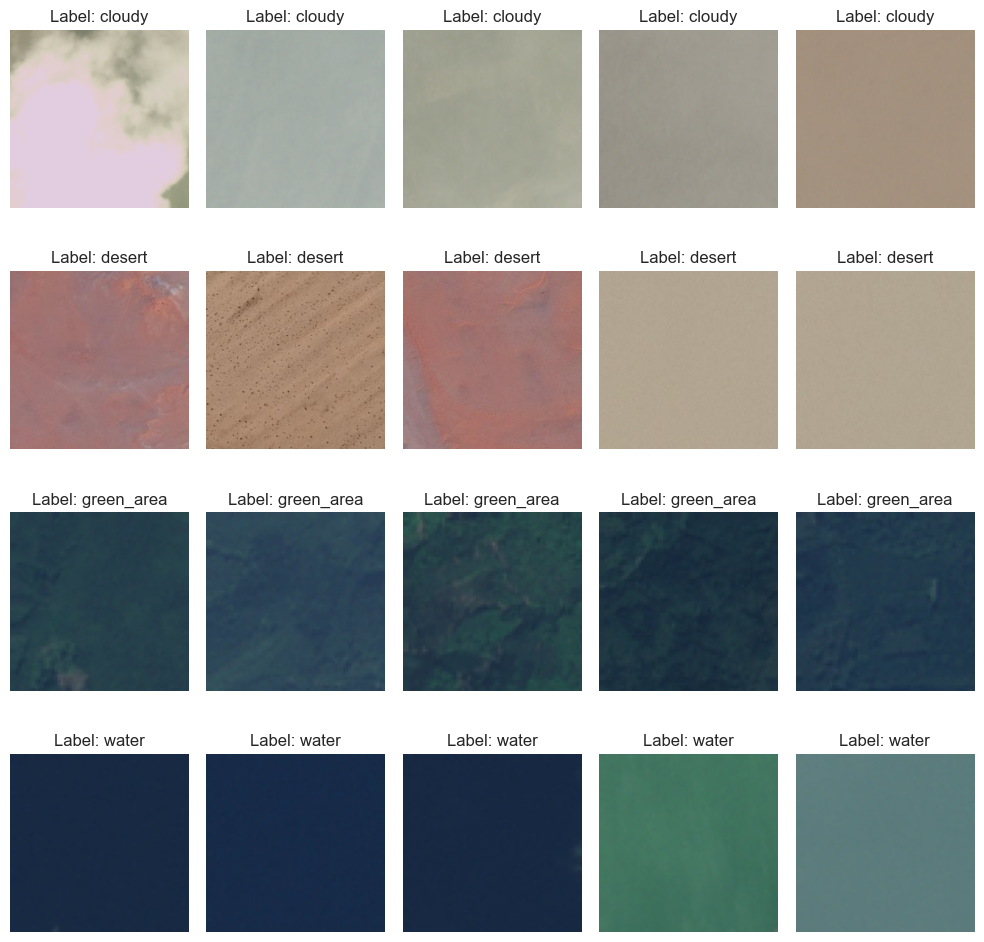

In [18]:
# Dictionary to store sample images for each label
data_dir = "data"
sample_images_per_label = {}

# Loop through the dataset folder and read images
for label_folder in os.listdir(data_dir):
    label_folder_path = os.path.join(data_dir, label_folder)
    label = label_folder
    if os.path.isdir(label_folder_path):
        images = filter(lambda img_file: os.path.isfile(os.path.join(label_folder_path, img_file)),
                        os.listdir(label_folder_path))
        images = list(images)[:5]  # Take only the first 5 images
        sample_images_per_label[label] = [Image.open(os.path.join(label_folder_path, img_file)) for img_file in images]

# Display the sample images for each label
plt.figure(figsize=(10, 10))
for i, (label, sample_images) in enumerate(sample_images_per_label.items()):
    for j, img in enumerate(sample_images):
        plt.subplot(len(sample_images_per_label), 5, i * 5 + j + 1)
        plt.imshow(img)  # No need to permute dimensions for PIL images
        plt.title(f'Label: {label}')
        plt.axis('off')
plt.tight_layout()
plt.show()

In [19]:
# Define the path to the root folder containing class-labeled subfolders
data_dir = "data"
img_dims = 64

# Test set transforms
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_dims, img_dims)),
])

# Train set transforms with data augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Resize((img_dims, img_dims)),
])

# Load test and train datasets
dataset_test = ImageFolder(data_dir, transform=test_transforms)
dataset_train = ImageFolder(data_dir, transform=train_transforms)

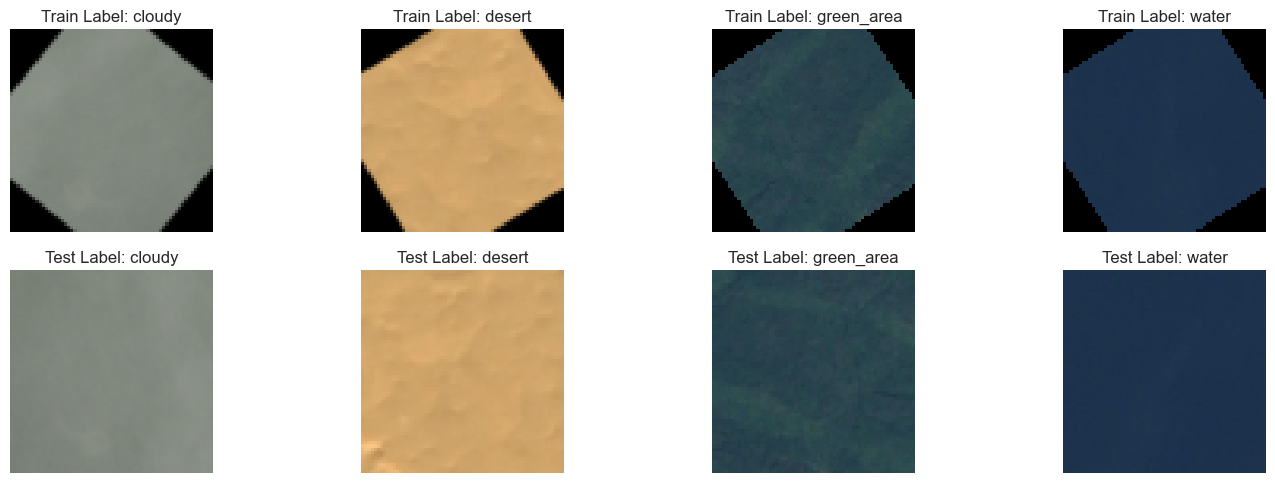

In [20]:

# Dictionary to store sample images for each label
sample_images_train = {}
sample_images_test = {}

# Get random index for each label from the train set
label_indexes = {label_folder: [] for label_folder in dataset_train.classes}

# Get random index for each label from the train set
for i, (image, label) in enumerate(dataset_train):
    label_folder = dataset_train.classes[label]
    label_indexes[label_folder].append(i)

# Randomly select one index for each label
random_label_indexes = {label_folder: random.choice(indexes) for label_folder, indexes in label_indexes.items()}

# Fetch images from the train and test sets using random indexes
sample_images_train = {label_folder: dataset_train[index][0].squeeze() for label_folder, index in random_label_indexes.items()}
sample_images_test = {label_folder: dataset_test[index][0].squeeze() for label_folder, index in random_label_indexes.items()}

# Plot the images
num_classes = len(sample_images_train)
plt.figure(figsize=(15, 5))
for i, (label_folder, sample_image_train) in enumerate(sample_images_train.items()):
    plt.subplot(2, num_classes, i + 1)
    plt.imshow(sample_image_train.permute(1, 2, 0))
    plt.title(f'Train Label: {label_folder}')
    plt.axis('off')

    plt.subplot(2, num_classes, num_classes + i + 1)
    plt.imshow(sample_images_test[label_folder].permute(1, 2, 0))
    plt.title(f'Test Label: {label_folder}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [21]:
# Set seed for reproducibility
torch.manual_seed(42)
random.seed(42)

# Define the split ratio for train and test sets
train_ratio = 0.8  # 80% of data for training, 20% for testing

# Determine the sizes of train and test sets
train_size = int(train_ratio * len(dataset_train))
test_size = len(dataset_train) - train_size

# Create indices for train and test sets
indices = list(range(len(dataset_train)))
random.shuffle(indices)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Define samplers for train and test sets
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

Using device: cuda

NVIDIA GeForce RTX 4060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.2 GB
Epoch [10/500], Train Loss: 0.6232, Test Loss: 0.5957
Epoch [20/500], Train Loss: 0.5138, Test Loss: 0.4963
Epoch [30/500], Train Loss: 0.4703, Test Loss: 0.4488
Epoch [40/500], Train Loss: 0.4434, Test Loss: 0.4249
Epoch [50/500], Train Loss: 0.4207, Test Loss: 0.4040
Epoch [60/500], Train Loss: 0.4028, Test Loss: 0.3899
Epoch [70/500], Train Loss: 0.3870, Test Loss: 0.3847
Epoch [80/500], Train Loss: 0.3792, Test Loss: 0.3719
Epoch [90/500], Train Loss: 0.3706, Test Loss: 0.3618
Epoch [100/500], Train Loss: 0.3660, Test Loss: 0.3524
Epoch [110/500], Train Loss: 0.3629, Test Loss: 0.3466
Epoch [120/500], Train Loss: 0.3598, Test Loss: 0.3547
Epoch [130/500], Train Loss: 0.3606, Test Loss: 0.3470
Epoch [140/500], Train Loss: 0.3526, Test Loss: 0.3366
Epoch [150/500], Train Loss: 0.3528, Test Loss: 0.3361
Epoch [160/500], Train Loss: 0.3481, Test Loss: 0.3333
Epoch [170/500], Train Loss: 0.3

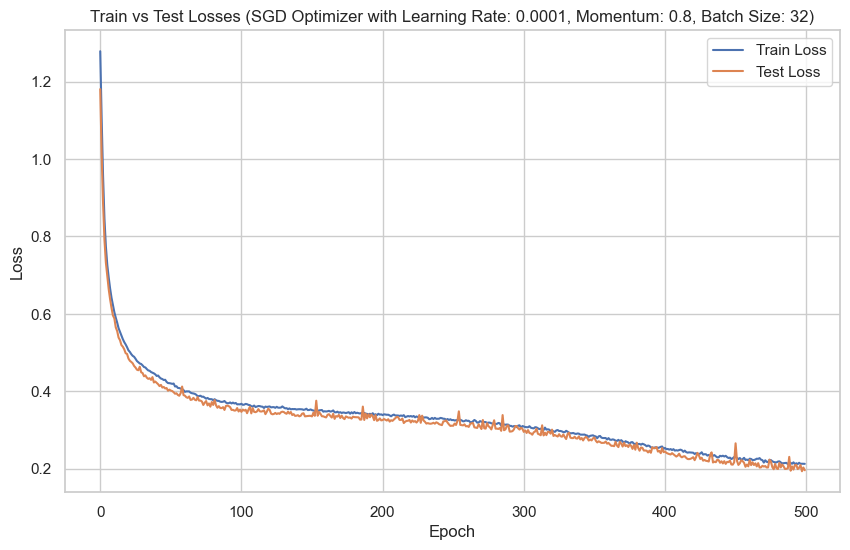

Using device: cuda

NVIDIA GeForce RTX 4060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.2 GB
Epoch [10/500], Train Loss: 0.2043, Test Loss: 0.1902
Epoch [20/500], Train Loss: 0.2032, Test Loss: 0.1901
Epoch [30/500], Train Loss: 0.2051, Test Loss: 0.1962
Epoch [40/500], Train Loss: 0.1979, Test Loss: 0.1942
Epoch [50/500], Train Loss: 0.2009, Test Loss: 0.1862
Epoch [60/500], Train Loss: 0.2003, Test Loss: 0.1965
Epoch [70/500], Train Loss: 0.1953, Test Loss: 0.1827
Epoch [80/500], Train Loss: 0.1936, Test Loss: 0.1832
Epoch [90/500], Train Loss: 0.1949, Test Loss: 0.1848
Epoch [100/500], Train Loss: 0.1911, Test Loss: 0.1801
Epoch [110/500], Train Loss: 0.1911, Test Loss: 0.1937
Epoch [120/500], Train Loss: 0.1861, Test Loss: 0.1765
Epoch [130/500], Train Loss: 0.1893, Test Loss: 0.1768
Epoch [140/500], Train Loss: 0.1894, Test Loss: 0.1752
Epoch [150/500], Train Loss: 0.1851, Test Loss: 0.1866
Epoch [160/500], Train Loss: 0.1830, Test Loss: 0.1720
Epoch [170/500], Train Loss: 0.1

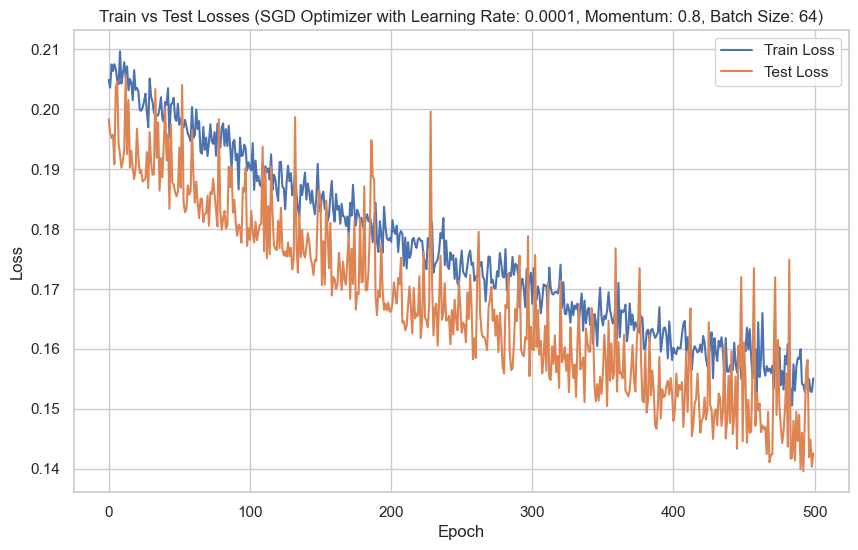

In [22]:
# List of batch sizes to iterate over
batch_sizes = [32, 64]
learning_rate = 0.0001
num_epochs = 500
momentum = 0.80
num_classes = len(os.listdir(data_dir))

# Instantiate the simplified model
net = Net(num_classes=num_classes)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer with the current learning rate
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

for batch_size in batch_sizes:
    # DataLoader for training set 
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    
    # DataLoader for test set
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, sampler=test_sampler)

    # Call the train_model function with timer
    start_time = time.time()
    # Call the train_model function
    train_losses, test_losses = train_model(net, optimizer, criterion, dataloader_train, dataloader_test, num_epochs)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Time to train (in seconds): {execution_time}")

    # Evalaute the model precision, accuracy and recall for each class, and overall average
    evaluate_model(net, dataset_test=dataset_test, dataloader_test=dataloader_test, num_classes=num_classes)

    # Plot train vs test set losses
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs Test Losses (SGD Optimizer with Learning Rate: {learning_rate}, Momentum: {momentum}, Batch Size: {batch_size})')
    plt.legend()
    plt.show()

Using device: cuda

NVIDIA GeForce RTX 4060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.2 GB
Epoch [10/500], Train Loss: 0.3640, Test Loss: 0.3790
Epoch [20/500], Train Loss: 0.3187, Test Loss: 0.2914
Epoch [30/500], Train Loss: 0.2733, Test Loss: 0.2506
Epoch [40/500], Train Loss: 0.2269, Test Loss: 0.2807
Epoch [50/500], Train Loss: 0.2052, Test Loss: 0.2264
Epoch [60/500], Train Loss: 0.1969, Test Loss: 0.1794
Epoch [70/500], Train Loss: 0.1784, Test Loss: 0.1608
Epoch [80/500], Train Loss: 0.1628, Test Loss: 0.2052
Epoch [90/500], Train Loss: 0.1749, Test Loss: 0.1716
Epoch [100/500], Train Loss: 0.1543, Test Loss: 0.1646
Epoch [110/500], Train Loss: 0.1708, Test Loss: 0.1464
Epoch [120/500], Train Loss: 0.1470, Test Loss: 0.1592
Epoch [130/500], Train Loss: 0.1488, Test Loss: 0.1417
Epoch [140/500], Train Loss: 0.1541, Test Loss: 0.1460
Epoch [150/500], Train Loss: 0.1275, Test Loss: 0.1437
Epoch [160/500], Train Loss: 0.1306, Test Loss: 0.1378
Epoch [170/500], Train Loss: 0.1

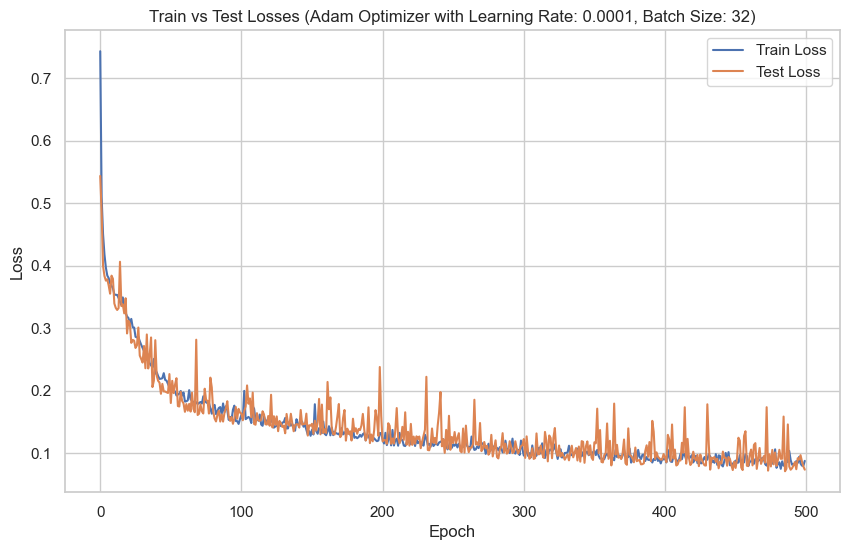

Using device: cuda

NVIDIA GeForce RTX 4060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.2 GB
Epoch [10/500], Train Loss: 0.0700, Test Loss: 0.0720
Epoch [20/500], Train Loss: 0.0721, Test Loss: 0.0710
Epoch [30/500], Train Loss: 0.0716, Test Loss: 0.0716
Epoch [40/500], Train Loss: 0.0765, Test Loss: 0.0726
Epoch [50/500], Train Loss: 0.0792, Test Loss: 0.0771
Epoch [60/500], Train Loss: 0.0687, Test Loss: 0.0721
Epoch [70/500], Train Loss: 0.0701, Test Loss: 0.0840
Epoch [80/500], Train Loss: 0.0795, Test Loss: 0.0719
Epoch [90/500], Train Loss: 0.0689, Test Loss: 0.0867
Epoch [100/500], Train Loss: 0.0661, Test Loss: 0.0920
Epoch [110/500], Train Loss: 0.0730, Test Loss: 0.1027
Epoch [120/500], Train Loss: 0.0727, Test Loss: 0.0637
Epoch [130/500], Train Loss: 0.0680, Test Loss: 0.0646
Epoch [140/500], Train Loss: 0.0678, Test Loss: 0.0930
Epoch [150/500], Train Loss: 0.0689, Test Loss: 0.0628
Epoch [160/500], Train Loss: 0.0865, Test Loss: 0.0972
Epoch [170/500], Train Loss: 0.0

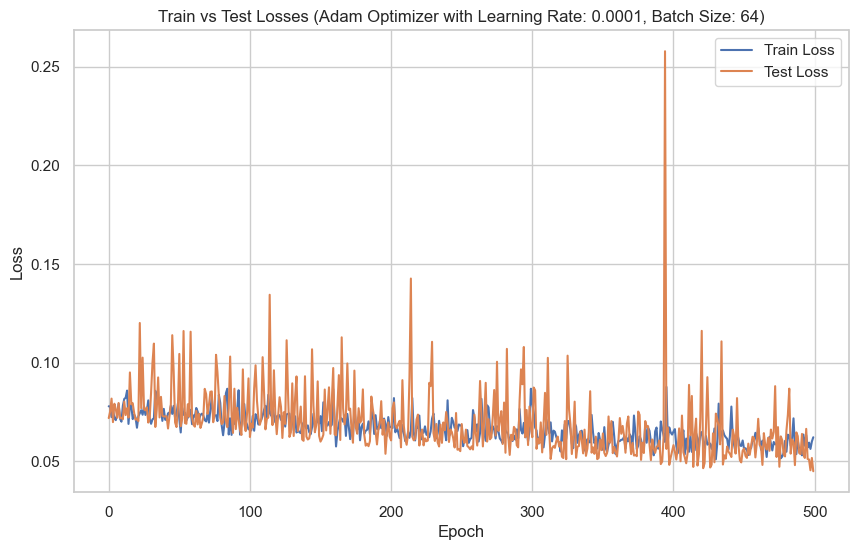

In [23]:
# List of batch sizes to iterate over
batch_sizes = [32, 64]
learning_rate = 0.0001
num_epochs = 500
num_classes = len(os.listdir(data_dir))

# Instantiate the simplified model
net = Net(num_classes=num_classes)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer with the current learning rate
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

for batch_size in batch_sizes:
    # DataLoader for training set
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    
    # DataLoader for test set
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, sampler=test_sampler)

    # Call the train_model function with timer
    start_time = time.time()
    # Call the train_model function
    train_losses, test_losses = train_model(net, optimizer, criterion, dataloader_train, dataloader_test, num_epochs)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Time to train (in seconds): {execution_time}")

    
    # Evalaute the model precision, accuracy and recall for each class, and overall average
    evaluate_model(net, dataset_test=dataset_test, dataloader_test=dataloader_test, num_classes=num_classes)


    # Plot train vs test set losses
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs Test Losses (Adam Optimizer with Learning Rate: {learning_rate}, Batch Size: {batch_size})')
    plt.legend()
    plt.show()